In [85]:
import pandas as pd

# Read the data
data = pd.read_csv('data_reduced.csv')
data.head()

# drop the name column
data = data.drop('name', axis=1)
data = data.drop('genders', axis=1)

# create BMI column by dividing weight in kg by height in meters squared
data['BMI'] = round(data['weight'] / (data['height'] / 100) ** 2, 2)

# sort the data by BMI
data = data.sort_values(by=['BMI'])
data

,age,height,weight,income,BMI
7,53.65,185,3.0,M,0.88
11,53.65,292,18.0,M,2.11
13,29.94,211,10.0,M,2.25
0,87.00,316,26.0,H,2.60
16,29.94,211,13.0,H,2.92
17,87.00,212,18.0,H,4.00
6,87.00,214,66.0,M,14.41
4,29.94,213,90.0,L,19.84
10,53.65,217,118.0,H,25.06
15,29.94,207,118.0,H,27.54


1. Let T be the set of training instances.
2. Choose an attribute that best differentiates the instances in T.
3. Create a tree node whose value is the chosen attribute.
    - Create child links from this node where each link represents a unique value for the chosen attribute.
    - Use the child link values to further subdivide the instances into subclasses.
4. For each subclass created in step 3:
    - If the instances in the subclass satisfy predefined criteria or if the set of remaining attribute choices for this path is null, specify the classification for new instances following this decision path.
    - If the subclass does not satisfy the criteria and there is at least one attribute to further subdivide the path of the tree, let T be the current set of subclass instances and return to step 2.

##### Information Gain -Entropy
- In order to define information gain precisely, we use a measure commonly used in information theory, called entropy
- Entropy characterizes the (im)purity of an arbitrary collection of examples.
- Given a collection S, containing positive and negative examples of some target concept, the entropy of S relative to this binary classification is:
$$ Entropy(S) = -(p+ log_2p+ + p- log_2p- ) $$

- S is a sample of training examples
- p+ is the proportion of positive examples
- p- is the proportion of negative examples
> entropy is a measure of the impurity in a collection of training examples

#### Attribute Selection Measure: Information Gain (ID3/C4.5)

- Select the attribute with the highest information gain
- Let pi be the probability that an arbitrary tuple in D belongs to class Ci, estimated by |Ci, D|/|D|
- Expected information (entropy) needed to classify a tuple in D:
$$ Info(D) = -\sum_{i=1}^{m}p_i log_2p_i $$

- Information needed (after using A to split D into v partitions) to classify D:
$$ Info_A(D) = \sum_{j=1}^{v}\frac{|D_j|}{|D|}Info(D_j) $$

- Information gain (reduction in entropy) due to partitioning D by A: (Information gained by branching on attribute A)
$$ Gain(A) = Info(D) - Info_A(D) $$

In [86]:
# Calculate Information Gain D for for BMI on class income
# Calculate the entropy of the whole dataset step by step

import numpy as np

info_d = 0
for i in data['income'].unique():
    p = len(data[data['income'] == i]) / len(data)
    info_d += -p * np.log2(p)
info_d = round(info_d, 2)

print('Entropy of the whole dataset on income Info(D): ', info_d)

# calculate the informations for each column
info_columns = {}
for col in data.columns:
    if col != 'income':
        info_columns[col] = 0
        for i in data[col].unique():
            p = len(data[data[col] == i]) / len(data)
            info_columns[col] += -p * np.log2(p)
        info_columns[col] = round(info_columns[col], 2)

print('Information for each column: ', info_columns)

Entropy of the whole dataset on income Info(D):  1.58
Information for each column:  {'age': 1.57, 'height': 4.12, 'weight': 4.02, 'BMI': 4.32}


In [87]:
# - Information needed (after using A to split D into v partitions) to classify D:
# Info_A(D) = sum over v of (|Dv|/|D|) * Info(Dv)

info_a_d = {}
for col in data.columns:
    if col != 'income':
        for i in data[col].unique():
            p = len(data[data[col] == i]) / len(data)
            info_a_d[col] = p * info_columns[col]
        info_a_d[col] = round(info_a_d[col], 2)

print('Information needed to classify D after using A to split D into v partitions: ', info_a_d)

Information needed to classify D after using A to split D into v partitions:  {'age': 0.47, 'height': 0.21, 'weight': 0.2, 'BMI': 0.22}


In [88]:
# - Information Gain: Info Gain(A) = Info(D) - Info_A(D)

# Calculate the information gain for each column
info_gain = {}
for col in data.columns:
    if col != 'income':
        info_gain[col] = info_d
        for i in data[col].unique():
            p = len(data[data[col] == i]) / len(data)
            info_gain[col] += -p * np.log2(p)
        info_gain[col] = round(info_gain[col], 2)

print('Information gain for each column: ', info_gain)

Information gain for each column:  {'age': 3.15, 'height': 5.7, 'weight': 5.6, 'BMI': 5.9}


In [89]:
# find the best column to split the data
best_col = max(info_gain, key=info_gain.get)
print('Best column to split the data: ', best_col)

Best column to split the data:  BMI


In [103]:
def calculate_info_gain(data, info_d):
    info_gain = {}
    for col in data.columns:
        if col != 'income':
            info_gain[col] = info_d
            for i in data[col].unique():
                p = len(data[data[col] == i]) / len(data)
                info_gain[col] += -p * np.log2(p)
            info_gain[col] = round(info_gain[col], 2)
    return info_gain

def calculate_best_col(data, info_d):
    info_gain = calculate_info_gain(data, info_d)
    best_col = max(info_gain, key=info_gain.get)
    return best_col

def split_data(data, best_col):
    data_1 = data[data[best_col] <= data[best_col].median()]
    data_2 = data[data[best_col] > data[best_col].median()]
    return data_1, data_2

# cal the info gain for the whole dataset and build the tree
def build_tree(data, info_d):
    info_gain = calculate_info_gain(data, info_d)
    best_col = max(info_gain, key=info_gain.get)
    data_1, data_2 = split_data(data, best_col)
    if len(data_1['income'].unique()) == 1:
        print('Leaf node: ', data_1['income'].unique(), 'Split point: ', data[best_col].median())
    else:
        print('Best column to split the data: ', best_col, 'Split point: ', data[best_col].median())
        build_tree(data_1, info_d)
    if len(data_2['income'].unique()) == 1:
        print('Leaf node: ', data_2['income'].unique(), 'Split point: ', data[best_col].median())
    else:
        # print the best column to split the data
        print('Best column to split the data: ', best_col, 'Split point: ', data[best_col].median())
        build_tree(data_2, info_d)

build_tree(data, info_d)

Best column to split the data:  BMI Split point:  27.595
Best column to split the data:  BMI Split point:  3.46
Best column to split the data:  weight Split point:  13.0
Leaf node:  ['M'] Split point:  10.0
Leaf node:  ['H'] Split point:  10.0
Best column to split the data:  weight Split point:  13.0
Leaf node:  ['M'] Split point:  70.325
Leaf node:  ['H'] Split point:  70.325
Best column to split the data:  BMI Split point:  3.46
Best column to split the data:  height Split point:  213.0
Leaf node:  ['H'] Split point:  212.0
Leaf node:  ['L'] Split point:  212.0
Best column to split the data:  height Split point:  213.0
Leaf node:  ['H'] Split point:  70.325
Leaf node:  ['M'] Split point:  70.325
Best column to split the data:  BMI Split point:  27.595
Best column to split the data:  height Split point:  167.0
Best column to split the data:  height Split point:  154.0
Leaf node:  ['M'] Split point:  152.0
Leaf node:  ['L'] Split point:  152.0
Best column to split the data:  height Spl

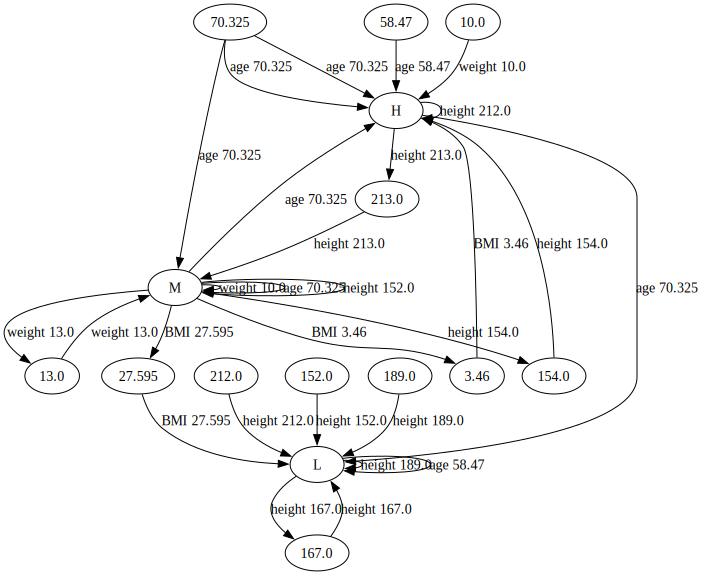

In [105]:
from graphviz import Digraph

def build_tree_recursively_and_draw_graph(data, info_d, tree):
    info_gain = calculate_info_gain(data, info_d)
    best_col = max(info_gain, key=info_gain.get)
    data_1, data_2 = split_data(data, best_col)
    if len(data_1['income'].unique()) == 1:
        tree.node(str(data_1['income'].unique()[0]))
        tree.edge(str(data['income'].unique()[0]), str(data_1['income'].unique()[0]), label=best_col + ' ' + str(data[best_col].median()))
    else:
        tree.node(str(data[best_col].median()))
        tree.edge(str(data['income'].unique()[0]), str(data[best_col].median()), label=best_col + ' ' + str(data[best_col].median()))
        build_tree_recursively_and_draw_graph(data_1, info_d, tree)
    if len(data_2['income'].unique()) == 1:
        tree.node(str(data_2['income'].unique()[0]))
        tree.edge(str(data[best_col].median()), str(data_2['income'].unique()[0]), label=best_col + ' ' + str(data[best_col].median()))
    else:
        tree.node(str(data[best_col].median()))
        tree.edge(str(data[best_col].median()), str(data_2['income'].unique()[0]), label=best_col + ' ' + str(data[best_col].median()))
        build_tree_recursively_and_draw_graph(data_2, info_d, tree)
    return tree

tree = build_tree_recursively_and_draw_graph(data, info_d, Digraph())
tree